<a href="https://colab.research.google.com/github/VanHoann/Yelp_Dataset_Challenges/blob/main/Sentiment_Analysis/Legacy/Baseline1_TF_IDF%2BSklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General pipeline for project 1
This is an example pipeline showing you how to  
(1) Load the provided data;  
(2) Train models on the train set, and use the validation set to evaluate your model performance;  
(3) Generate predictions (pred.csv) on the test set, which is ready for submission.

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

### (1) Loading data
The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "stars" column) for the test set. You may evaluate your trained model on the validation set instead.

However, your submitted predictions (``pred.csv``) should be generated on the test set.

In [2]:
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [3]:
data_dir = "https://raw.githubusercontent.com/VanHoann/Yelp_Dataset_Challenges/main/Sentiment_Analysis/data"

train_df = load_data('train', columns=['text', 'stars'], folder=data_dir)
valid_df = load_data('valid', columns=['text', 'stars'], folder=data_dir)
test_df = load_data('test', columns=['text', 'review_id'], folder=data_dir)

select [text, stars] columns from the train split
Success
select [text, stars] columns from the valid split
Success
select [text, review_id] columns from the test split
Success


In [4]:
print(train_df['stars'].value_counts(),
      valid_df['stars'].value_counts(),
      train_df.head(5), sep='\n'
)

5    7911
4    3971
1    2672
3    1989
2    1457
Name: stars, dtype: int64
5    904
4    466
1    282
3    212
2    136
Name: stars, dtype: int64
                                                text  stars
0  I've been here a handful of times now and I've...      5
1  The service was terrible. The food was just ok...      1
2  Alil pricey for the location but completly get...      4
3  Don't get your car washed here. Paid 11 and my...      1
4  Cute but tight. Not expensive and creative. I ...      5


In [5]:
# Prepare the data.
# As an example, we only use the text data. 
x_train = train_df['text']
y_train = train_df['stars']#.apply(lambda x: 3 if (2 <= x and x <= 4) else x)

x_valid = valid_df['text']
y_valid = valid_df['stars']#.apply(lambda x: 3 if (2 <= x and x <= 4) else x)

x_test = test_df['text']

### (1.1) Data Exploration

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = set(stopwords.words("english"))
print(sw)
# all are important words for sentiment analysis @@

{'same', 'myself', 'him', 'weren', 'a', 'after', 'yourselves', 'been', "haven't", 'between', 'when', 'their', 'do', 'so', 'my', 'was', 'where', 'again', 'of', "it's", "wouldn't", 'and', 'wasn', 'can', 'under', "that'll", 'before', 'own', 'about', 'doing', 'than', 'wouldn', 'ain', 'yourself', 'had', 'it', 'up', 'whom', 'how', 'both', 'too', 'y', 'shouldn', 'she', 'ours', 'out', 'having', 'other', 'now', "doesn't", 't', 'each', 'yours', 'few', 'through', "shouldn't", "won't", 'mustn', 'o', 'further', 'off', 'above', 'll', 'isn', "she's", 'not', "couldn't", 'who', 'has', "hasn't", 'd', 's', 'aren', "you've", 'then', 'our', 'why', 'the', 'that', 'should', 'his', 'itself', 'haven', "hadn't", 'being', 'be', 'is', 'your', 'will', 'am', 've', 'hasn', 'while', 'during', 'with', 'on', 'but', 'her', 'we', 'm', 'or', 'no', 'there', 'in', 'some', 'for', 'below', 'doesn', "don't", "shan't", 'which', 'hadn', 'at', 'them', 'against', 'most', 'into', 'down', 'needn', 'theirs', "isn't", 'such', 'if', 'o

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
pattern = 'best'
for i in range(1,6):
    print(sum((x_train.apply(lambda x: pattern in x) * (y_train == i)).astype('int32'))/y_train.value_counts()[i],
          sum((x_valid.apply(lambda x: pattern in x) * (y_valid == i)).astype('int32'))/y_valid.value_counts()[i])

0.053517964071856286 0.05673758865248227
0.10020590253946465 0.08823529411764706
0.10055304172951232 0.13679245283018868
0.12364643666582725 0.10085836909871244
0.1776008090001264 0.17256637168141592


#### tSNE plot

In [8]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def plot_scatter(tsne_data, colors):
    # choose a color palette with seaborn.
    tsne_data = np.vstack((tsne_data.T, colors)).T
    tsne_df = pd.DataFrame(data = tsne_data,
         columns =("Dim_1", "Dim_2", "label"))
      
    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, hue ="label", size = 6).map(
           plt.scatter, 'Dim_1', 'Dim_2').add_legend()
      
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


x_tsne [[ 5.6048126 -4.964953 ]
 [-1.8925803  0.7042772]
 [-9.533467  -6.68443  ]
 ...
 [-2.460132   2.03553  ]
 [-4.2058315 -6.8359666]
 [-2.2081647  6.142149 ]]
y [5 4 4 ... 5 5 5]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


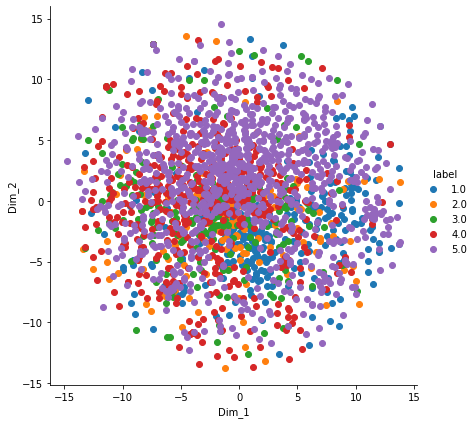

In [10]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf.fit(x_train)
x_embeds = tfidf.transform(x_valid)

x_tsne = TSNE().fit_transform(x_embeds)
y = np.array(y_valid)
print('x_tsne',x_tsne)
print('y',y)

plot_scatter(x_tsne, y)
# too many data of high dimension -> tSNE plot is not meaningful

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


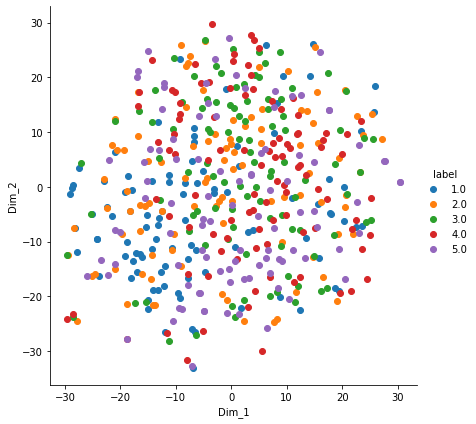

In [11]:
# use smaller set of data
aggre_df = pd.DataFrame({'text':[], 'stars':[]})
num_per_class = 100

for s in range(1,6):
    temp = train_df[train_df['stars']==s]
    aggre_df = aggre_df.append(temp[:num_per_class])

x_embeds = tfidf.transform(aggre_df['text'])

x_tsne = TSNE().fit_transform(x_embeds)
y = np.array(aggre_df['stars'])

plot_scatter(x_tsne, y)
# still very chaostic

#### Wordcloud to observe word frequency

In [15]:
from collections import Counter
from wordcloud.wordcloud import WordCloud, STOPWORDS

# let see which words exist the most in each 'voting' class
most_common_words = [[] for i in range(5)]

for v in range(1,6):
    corpus = ' '.join(train_df['text'][train_df['stars'] == v].to_list())
    bow = corpus.lower().split(' ')
    count_list = Counter(bow)
    print('-'*10, 'voting {}'.format(v), '-'*10)
    for w, c in count_list.most_common(100):
        if w not in STOPWORDS: # stopwords.words('english'):
            print(w, c)
            most_common_words[v-1].append(w)

---------- voting 1 ----------
 5395
one 1151
told 1015
will 1003
food 978
even 969
back 969
time 947
place 945
us 919
never 914
go 914
said 884
service 878
got 773
asked 679
went 646
came 643
good 572
minutes 542
called 542
people 537
going 533
ordered 524
know 521
another 520
---------- voting 2 ----------
 3816
food 811
one 628
place 576
good 549
time 490
really 445
service 440
got 418
even 410
ordered 408
came 406
go 400
back 375
- 361
us 327
will 319
went 308
order 301
much 284
two 276
first 273
little 265
said 264
---------- voting 3 ----------
 4015
food 1050
good 970
place 869
one 682
really 671
service 547
time 539
go 501
got 501
pretty 479
ordered 463
back 445
great 436
- 425
will 419
little 417
nice 381
much 379
came 377
bit 344
us 329
chicken 321
---------- voting 4 ----------
 7359
good 1858
place 1772
great 1645
food 1592
really 1286
one 1188
- 896
go 894
nice 893
little 887
time 865
will 862
service 851
got 726
back 726
always 690
definitely 683
ordered 679
pretty 653
lo

In [16]:
bow = []
for i in range(5):
    bow += most_common_words[i]
count_list = Counter(bow)
for w,c in count_list.most_common():
    print(w, c)

 5
one 5
will 5
food 5
back 5
time 5
place 5
go 5
service 5
got 5
good 5
even 4
us 4
came 4
ordered 4
really 4
- 4
much 3
little 3
great 3
nice 3
said 2
went 2
order 2
first 2
pretty 2
bit 2
chicken 2
always 2
definitely 2
love 2
best 2
told 1
never 1
asked 1
minutes 1
called 1
people 1
going 1
know 1
another 1
two 1
come 1
try 1
recommend 1
staff 1
friendly 1
made 1
new 1
amazing 1


In [17]:
for i in range(5):
    for j in range(i+1,5):
        print(i,j)
        mcw_i = most_common_words[i]
        mcw_j = most_common_words[j]
        print('set {} minus set {}'.format(i+1,j+1), set(mcw_i).difference(mcw_j))
        print('set {} minus set {}'.format(j+1,i+1), set(mcw_j).difference(mcw_i))

0 1
set 1 minus set 2 {'going', 'minutes', 'people', 'asked', 'another', 'told', 'called', 'know', 'never'}
set 2 minus set 1 {'-', 'two', 'much', 'first', 'order', 'little', 'really'}
0 2
set 1 minus set 3 {'going', 'minutes', 'know', 'people', 'went', 'even', 'asked', 'another', 'told', 'said', 'called', 'never'}
set 3 minus set 1 {'pretty', '-', 'bit', 'chicken', 'much', 'little', 'great', 'nice', 'really'}
0 3
set 1 minus set 4 {'going', 'minutes', 'know', 'people', 'went', 'asked', 'another', 'told', 'us', 'said', 'called', 'never'}
set 4 minus set 1 {'-', 'pretty', 'bit', 'chicken', 'much', 'order', 'little', 'try', 'come', 'love', 'great', 'always', 'definitely', 'best', 'nice', 'really'}
0 4
set 1 minus set 5 {'going', 'minutes', 'know', 'people', 'went', 'asked', 'another', 'told', 'said', 'called', 'ordered', 'came', 'never'}
set 5 minus set 1 {'-', 'made', 'recommend', 'friendly', 'love', 'staff', 'new', 'amazing', 'great', 'first', 'always', 'definitely', 'best', 'nice', 'r

### (2) Training and validating ⭐
The following example shows you how to train your model using the train set, and evaluate on the validation set.  
As an example, we only use the text data for training. Feel free to use other columns in your implementation.  

The model performance on the validation set can be roughly regarded as your models final performance, so we can use it to search for optimal hyper-parameters.

#### Results table ⭐


Validation Performance | Macro-F1|Precision	|Recall|Accuracy
-----------------------|---------|----------|------|--------
Weak baseline	| 0.4270|0.5420 |0.4325|0.6135
Strong baseline | 0.5370|


Our model | Marco-F1 | Note
----------|----------|--------
SGDClassifier(loss='log', alpha=1) | 0.1245 | all predictions are 5
MultinomialNB() | 0.15x | most of predictions are 5
MultinomialNB(alpha=0.001) | 0.3966 | not good
-- LogisticR, fixed plain Tfidf() | | NOTE: weight scaling DOES affect model performance
(C=1, class_weight=None) | 0.5279 | a bit worse than strong baseline
(C=1, class_weight=[3,6,4,2,1]) | 0.54x |
(C=2, class_weight=None) | 0.5362 | better
(C=2, class_weight='balanced') | 0.542 | better
(C=2, class_weight=[3,6,4,2,1]) | 0.5460 |
(C=2, class_weight=[3,10,10,2,1]) | 0.526 |
(C=3, class_weight=[3,6,4,2,1]) | 0.5465 |
-- Tfidf, fixed LR(C=3,cw=[3,6,4,2,1]) 
ngram=(1,2) | 0.5563 | better
ngram=(1,2), max_features=10000, binary=False | 0.5511 | DON'T use binarize vector! (actually use low_case=False)
ngram=(1,2), max_features=10000, binary=True | 0.5247 | use low_case=False
ngram=(1,2), max_features=30000, low_case=False | 0.5602 
ngram=(1,4) (yield 3m500k tokens @@) | 0.5730 | OMG!, but cost 6 mins instead of 15s, and acc is roughly the same at 0.65x
ngram=(1,4), lowercase=False | 0.5533 | @@ 7m20s to train, acc 0.6465
ngram=(1,4), max_features=30000, low_case=False | 0.5627 | ->> **best** + cheap
 + max_df=0.9 (min_df=5) | 0.55xx | accuracy also decreases to 0.63x
 + sublinear_tf=True, smooth_idf=True | 0.56x | acc=0.643, not improve
ngram=(1,4), max_features=30000 | 0.5512 | not recommended to use low_case=True as default 
ngram=(1,4), max_features=30000, low_case=False, stopw='english' | 0.5369 | accuracy also decreases -> don't use stop words @@ seem counter-intuitive!
ngram=(1,4), max_features=60000, low_case=False | 0.5489
ngram=(1,4), max_features=60000 | 0.5617 | wait, what?
-- MLPClassifier(hs=(100,)) | -- |fixed **best** Tfidf(ngram=(1,4), max_features=30000, low_case=False)
activation='relu', alpha=1e-2, lr="invscaling", 30 iters | 0.5647 | at iter 4
activation='relu', alpha=1e-2, lr="constant"/"adaptive", 10 iters | 0.5647 | at iter 4, no difference when using different lr
activation='relu', alpha=1e-2, lr_init = 0.0001 |  | learning slower vs default lr_init=0.001
activation='relu', alpha=1e-2, lr_init = 0.01 | 0.55x | at iter 1, then decline -> use default
activation='relu', alpha=1e-3 | 0.5585 | no diff, seem that param of MLP is not big
activation='relu', alpha=1e-1 | 0.5656 | at iter 9, then stable at 0.55x
activation='logistic', alpha=1e-1 | 0.264 | at iter 20/20, slowly better
activation='tanh', alpha=1e-1 | 0.5607 | at iter 8/20, slowly better
-- How many epochs to fit LR
200 | 0.5558
100 | 0.5627
50 | 0.5573
-- Ensemble
135 ([3,1,1]), 234 ([3,2,1]) | 0.5677


'LogisticRegression' object has no attribute 'partial_fit'

Using np.array is slower to fit LR than sparse matrix (output of tfidf)

Models will be evaluated by [Macro F1](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#989c)(unweighted avg of F1 score per class) on test data

In [18]:
import string, nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def text_clean(message):
    nopunc = [i for i in message if i not in string.punctuation]
    nn = "".join(nopunc)
    nn = nn.lower().split()
    nostop = [words for words in nn if words not in stopwords.words('english')]
    return(nostop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
## display loss during training
# https://stackoverflow.com/questions/44443479/python-sklearn-show-loss-values-during-training

import sys
import io
import matplotlib.pyplot as plt

class DisplayLossCurve(object):
  def __init__(self, print_loss=False):
    self.print_loss = print_loss

  """Make sure the model verbose is set to 1"""
  def __enter__(self):
    self.old_stdout = sys.stdout
    sys.stdout = self.mystdout = io.StringIO()
  
  def __exit__(self, *args, **kwargs):
    sys.stdout = self.old_stdout
    loss_history = self.mystdout.getvalue()
    loss_list = []
    for line in loss_history.split('\n'):
      if(len(line.split("loss: ")) == 1):
        continue
      loss_list.append(float(line.split("loss: ")[-1]))
    plt.figure()
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    if self.print_loss:
      print("=============== Loss Array ===============")
      print(np.array(loss_list))
      
    return True

 You can use the valid data to choose the hyperparameters.
As an example, you can decide which value of C (1 or 100) is better by evaluating on the valid data.

#### Get Tfidf embedding

In [20]:
tfidf = TfidfVectorizer(ngram_range=(1,4), #max_df=0.9, min_df=5,
                        max_features=30000,
                        lowercase=False)

x_train_embeds = tfidf.fit_transform(x_train)
x_valid_embeds = tfidf.transform(x_valid)

In [21]:
x_valid_embeds.shape

(2000, 30000)

#### MLP

In [22]:
from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(activation='relu',
                     alpha=1e-1,
                     random_state=44,
                     max_iter=100)

for i in range(1,15):
    mlp1.partial_fit(x_train_embeds, y_train, [1,2,3,4,5])

    if i%1 == 0:
        # validate on the validation set
        y_pred = mlp1.predict(x_valid_embeds)
        print('After training {} iterations'.format(i))
        print(f1_score(y_valid, y_pred, average='macro'))

After training 1 iterations
0.30355209169373293
After training 2 iterations
0.41608223342162487
After training 3 iterations
0.4834339583467459
After training 4 iterations
0.5196737640087669
After training 5 iterations
0.544806287092283
After training 6 iterations
0.5532375722630112
After training 7 iterations
0.554382874639308
After training 8 iterations
0.5571202719848026
After training 9 iterations
0.5642986482108558
After training 10 iterations
0.5656606183807659
After training 11 iterations
0.5644133156687069
After training 12 iterations
0.5602356080758004
After training 13 iterations
0.5618450034608076
After training 14 iterations
0.5633011107516204


#### Model 2

In [23]:
lr2 = LogisticRegression(C=3,
                         class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])}
                         )

# train the second model
lr2.fit(x_train_embeds, y_train)

# validate on the validation set
y_pred = lr2.predict(x_valid_embeds)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1     0.7061    0.7837    0.7429       282
           2     0.3380    0.3529    0.3453       136
           3     0.4155    0.4057    0.4105       212
           4     0.5139    0.5536    0.5331       466
           5     0.8134    0.7522    0.7816       904

    accuracy                         0.6465      2000
   macro avg     0.5574    0.5696    0.5627      2000
weighted avg     0.6540    0.6465    0.6492      2000




[[221  33  16   6   6]
 [ 43  48  37   7   1]
 [ 19  36  86  56  15]
 [ 13  16  45 258 134]
 [ 17   9  23 175 680]]
accuracy 0.6465


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [24]:
lr2 = LogisticRegression(C=3,
                         class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])},
                         solver='liblinear', random_state=1
                         )

# train the second model
lr2.fit(x_train_embeds, y_train)

# validate on the validation set
y_pred = lr2.predict(x_valid_embeds)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1     0.6939    0.8121    0.7484       282
           2     0.3475    0.3015    0.3228       136
           3     0.4144    0.3538    0.3817       212
           4     0.5140    0.4742    0.4933       466
           5     0.7843    0.8164    0.8000       904

    accuracy                         0.6520      2000
   macro avg     0.5508    0.5516    0.5492      2000
weighted avg     0.6396    0.6520    0.6445      2000




[[229  26  13   6   8]
 [ 49  41  38   7   1]
 [ 22  31  75  67  17]
 [ 14  15  39 221 177]
 [ 16   5  16 129 738]]
accuracy 0.652


#### Experiment with various models 

[Naive Bayes](https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a)
[Light GBM](https://stackoverflow.com/questions/50250432/python-lightgbm-text-classicication-with-tfidf)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)

neigh.fit(x_train_embeds, y_train)
y_pred = neigh.predict(x_valid_embeds)

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           1     0.4448    0.5000    0.4708       282
           2     0.0620    0.7647    0.1147       136
           3     1.0000    0.0094    0.0187       212
           4     1.0000    0.0021    0.0043       466
           5     0.0000    0.0000    0.0000       904

    accuracy                         0.1240      2000
   macro avg     0.5014    0.2553    0.1217      2000
weighted avg     0.4059    0.1240    0.0772      2000




[[141 141   0   0   0]
 [ 32 104   0   0   0]
 [ 27 182   2   0   1]
 [ 42 422   0   1   1]
 [ 75 829   0   0   0]]


In [27]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(criterion='entropy', 
                                  class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])},
                                  )
clf_RF.fit(x_train_embeds, y_train)
y_pred = clf_RF.predict(x_valid_embeds)

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           1     0.6524    0.4858    0.5569       282
           2     0.4000    0.0147    0.0284       136
           3     0.6000    0.0283    0.0541       212
           4     0.3113    0.0708    0.1154       466
           5     0.5231    0.9657    0.6786       904

    accuracy                         0.5255      2000
   macro avg     0.4974    0.3131    0.2867      2000
weighted avg     0.4918    0.5255    0.4198      2000




[[137   1   1   5 138]
 [ 44   2   1  11  78]
 [ 11   1   6  39 155]
 [  6   0   2  33 425]
 [ 12   1   0  18 873]]


In [28]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier, LGBMRegressor

clf_LGBM = lgbm.LGBMClassifier(objective='multiclass', verbose=-1, learning_rate=0.01, max_depth=20, 
                               num_leaves=32, n_estimators=120, max_bin=200, 
                            #    class_weight={i: w for i,w in enumerate([3,6,4,2,1])} # not use class weight -> 0.51
                               )
clf_LGBM.fit(x_train_embeds, y_train-1, verbose=True)
y_pred = clf_LGBM.predict(x_valid_embeds)

print(classification_report(y_valid-1, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid-1, y_pred))

              precision    recall  f1-score   support

           0     0.7006    0.4397    0.5403       282
           1     1.0000    0.0221    0.0432       136
           2     0.5000    0.0047    0.0093       212
           3     0.4184    0.0880    0.1454       466
           4     0.5116    0.9735    0.6707       904

    accuracy                         0.5245      2000
   macro avg     0.6261    0.3056    0.2818      2000
weighted avg     0.5485    0.5245    0.4172      2000




[[124   0   0   5 153]
 [ 25   3   1   8  99]
 [ 14   0   1  25 172]
 [  9   0   0  41 416]
 [  5   0   0  19 880]]


In [29]:
from sklearn.naive_bayes import MultinomialNB

# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer()

lr2 = MultinomialNB(alpha= 0.001)
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

# train the second model
pipe2.fit(x_train, y_train)

# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1     0.6059    0.6596    0.6316       282
           2     0.2545    0.1029    0.1466       136
           3     0.2727    0.0991    0.1453       212
           4     0.3569    0.3798    0.3680       466
           5     0.6394    0.7533    0.6917       904

    accuracy                         0.5395      2000
   macro avg     0.4259    0.3989    0.3966      2000
weighted avg     0.5038    0.5395    0.5128      2000




[[186  25   9  24  38]
 [ 41  14  25  30  26]
 [ 34  11  21  86  60]
 [ 18   1  10 177 260]
 [ 28   4  12 179 681]]
accuracy 0.5395


In [33]:
pipe2

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr', MultinomialNB(alpha=0.001))])

In [31]:
# on train set
y_pred = pipe2.predict(x_train)
print(classification_report(y_train, y_pred))
print("\n\n")
print(confusion_matrix(y_train, y_pred))
print('accuracy', np.mean(y_train == y_pred))

              precision    recall  f1-score   support

           1       0.90      0.94      0.92      2672
           2       0.97      0.81      0.88      1457
           3       0.96      0.79      0.86      1989
           4       0.86      0.82      0.84      3971
           5       0.89      0.97      0.93      7911

    accuracy                           0.90     18000
   macro avg       0.92      0.87      0.89     18000
weighted avg       0.90      0.90      0.90     18000




[[2505   34   36   46   51]
 [ 107 1186   21   82   61]
 [  76    5 1564  173  171]
 [  55    1    5 3267  643]
 [  36    2    4  219 7650]]
accuracy 0.8984444444444445


#### Ensemble of two LogisticReg

Our model | Marco-F1 | Accuracy | Note
----------|----------|----------|------
-- lr_135
w=[3,1,1] | 0.7574
w=[1,1,1] | 0.7487
w=[5,1,1] | 0.7517
-- Ensemble
135 ([3,1,1]), 234 ([3,2,1]) | 0.5677 
135 ([3,1,1]), 234 ([5,3,1]) | 0.5636 
135 ([3,1,1]), 234 ([10,5,1]) | 0.5569  
135 ([1,3,1]), 234 ([3,2,1]) | 0.5414 | 0.6020
135 ([2,1,1]), 234 ([3,2,1]) | 0.5651 | 0.6530  
135 (balanced), 234 (balanced) | 0.5654 | 0.6525 
- 12 + 45 + 135 cw
balanced balanced balanced  | 0.5585 | 0.6385
[2,4,1] balanced balanced  | 0.5763 | 0.657
[2,4,1] [2,3] balanced  | 0.5732 | 0.657
[2,4,1] [2,3] [3,2]  | 0.5711 | 0.6605
[1,3,1] balanced balanced | 0.5755 |0.6575    
(try other weight, just get similar result)

##### 135 + 234

In [37]:
y_train_135 = y_train.copy()
y_train_135[y_train_135.between(2,4)] = 3
print(np.unique(y_train_135))

y_valid_135 = y_valid.copy()
y_valid_135[y_valid_135.between(2,4)] = 3
print(np.unique(y_valid_135))

[1 3 5]
[1 3 5]


In [38]:
# x_train_embeds = tfidf.transform(x_train)

x_train_embeds_234 = tfidf.transform(x_train[y_train_135==3])
y_train_234 = y_train[y_train_135==3]
print(x_train_embeds_234, len(y_train_234))

x_valid_embeds_234 = tfidf.transform(x_valid[y_valid_135==3])
y_valid_234 = y_valid[y_valid_135==3]
print(x_valid_embeds_234, len(y_valid_234))

  (0, 36478)	0.1316013115766094
  (0, 32689)	0.10352116130855428
  (0, 31915)	0.18709120356121495
  (0, 25311)	0.23704722059321698
  (0, 24735)	0.20471035698888193
  (0, 22740)	0.0856437438589801
  (0, 19266)	0.16998054667575802
  (0, 14074)	0.11313589782719291
  (0, 13489)	0.19320817238906732
  (0, 13174)	0.13891277950366715
  (0, 7564)	0.4714224640095493
  (0, 5363)	0.08234384245666566
  (0, 5119)	0.32721843200481604
  (0, 3369)	0.3392467356242494
  (0, 1786)	0.4714224640095493
  (0, 33)	0.2445208914728616
  (1, 36465)	0.036441913424346564
  (1, 36153)	0.048398485449323195
  (1, 35924)	0.09642713575780644
  (1, 35816)	0.14553729665417023
  (1, 35627)	0.0986842856693934
  (1, 35626)	0.08229237774428562
  (1, 35500)	0.03998732576122383
  (1, 35439)	0.12161070151218958
  (1, 35425)	0.13396067255383895
  :	:
  (7416, 16066)	0.10929364635481673
  (7416, 15326)	0.13724422261852387
  (7416, 15005)	0.10769126016108722
  (7416, 14618)	0.058632572035954386
  (7416, 14372)	0.057368859461350515


In [39]:
lr_135 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced' #{i: w for i,w in zip([1,3,5],[3,1,1])}
                         )

lr_135.fit(x_train_embeds, y_train_135)

# validate on the validation set
y_pred_135 = lr_135.predict(x_valid_embeds)
print(classification_report(y_valid_135, y_pred_135, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_135, y_pred_135))
print('accuracy', np.mean(y_valid_135 == y_pred_135))

              precision    recall  f1-score   support

           1     0.7108    0.8191    0.7611       282
           3     0.7171    0.7101    0.7136       814
           5     0.8101    0.7788    0.7941       904

    accuracy                         0.7565      2000
   macro avg     0.7460    0.7693    0.7563      2000
weighted avg     0.7583    0.7565    0.7567      2000




[[231  46   5]
 [ 76 578 160]
 [ 18 182 704]]
accuracy 0.7565


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [40]:
lr_234 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced' #{i: w for i,w in zip([2,3,4],[3,2,1])}
                         )

lr_234.fit(x_train_embeds_234, y_train_234)

# validate on the validation set
y_pred_234 = lr_234.predict(x_valid_embeds_234)
print(classification_report(y_valid_234, y_pred_234, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_234, y_pred_234))
print('accuracy', np.mean(y_valid_234 == y_pred_234))

              precision    recall  f1-score   support

           2     0.4624    0.5882    0.5178       136
           3     0.4717    0.4717    0.4717       212
           4     0.8392    0.7725    0.8045       466

    accuracy                         0.6634       814
   macro avg     0.5911    0.6108    0.5980       814
weighted avg     0.6805    0.6634    0.6699       814




[[ 80  44  12]
 [ 55 100  57]
 [ 38  68 360]]
accuracy 0.6633906633906634


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [41]:
## end-to-end prediction
y_pred_135 = lr_135.predict(x_valid_embeds) #1:1, 3:234, 5:5
x_valid_embeds_3 = tfidf.transform(x_valid[y_pred_135==3])
y_pred_234 = lr_234.predict(x_valid_embeds_3) #2:2, 3:3, 4:4

y_pred = y_pred_135.copy()
y_pred[y_pred==3] = y_pred_234

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1     0.7108    0.8191    0.7611       282
           2     0.3007    0.3382    0.3183       136
           3     0.4017    0.4528    0.4257       212
           4     0.5193    0.4614    0.4886       466
           5     0.8101    0.7788    0.7941       904

    accuracy                         0.6460      2000
   macro avg     0.5485    0.5701    0.5576      2000
weighted avg     0.6504    0.6460    0.6469      2000




[[231  29  15   2   5]
 [ 44  46  36  10   0]
 [ 19  39  96  50   8]
 [ 13  26  60 215 152]
 [ 18  13  32 137 704]]
accuracy 0.646


##### 12 + 45 + 135

In [42]:
y_train_135 = y_train.copy()
y_train_135[y_train_135 < 3] = 1
y_train_135[y_train_135 > 3] = 5
print(np.unique(y_train_135))

y_valid_135 = y_valid.copy()
y_valid_135[y_valid_135 < 3] = 1
y_valid_135[y_valid_135 > 3] = 5
print(np.unique(y_valid_135))

[1 3 5]
[1 3 5]


In [44]:
y_train_12 = y_train.copy()
y_train_12 = y_train_12[y_train_12 < 3]
print(np.unique(y_train_12))

y_valid_12 = y_valid.copy()
y_valid_12 = y_valid_12[y_valid_12 < 3]
print(np.unique(y_valid_12))

[1 2]
[1 2]


In [45]:
y_train_45 = y_train.copy()
y_train_45 = y_train_45[y_train_45 > 3]
print(np.unique(y_train_45))

y_valid_45 = y_valid.copy()
y_valid_45 = y_valid_45[y_valid_45 > 3]
print(np.unique(y_valid_45))

[4 5]
[4 5]


Our model | Marco-F1 | Accuracy |class 3| Note
----------|----------|----------|-|------
-- lr_135
1,3,1 | 0.7382 | 0.8570 | 
1,10,1 | 0.7271 | 0.8350 |
balanced | 0.7300 | 0.8415 | 
2,4,1 | 0.7324 | 0.8565 | 0.4539
2,6,1 | 0.7342 | 0.8465 | 0.4719

Need to raise score of class 3

In [46]:
lr_135 = LogisticRegression(C=3, max_iter=100,
                         class_weight={i: w for i,w in zip([1,3,5],[2,4,1])}
                         )

lr_135.fit(x_train_embeds, y_train_135)

# validate on the validation set
y_pred_135 = lr_135.predict(x_valid_embeds)
print(classification_report(y_valid_135, y_pred_135, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_135, y_pred_135))
# print('accuracy', np.mean(y_valid_135 == y_pred_135))

              precision    recall  f1-score   support

           1     0.7790    0.8517    0.8137       418
           3     0.4815    0.4292    0.4539       212
           5     0.9350    0.9241    0.9295      1370

    accuracy                         0.8565      2000
   macro avg     0.7318    0.7350    0.7324      2000
weighted avg     0.8543    0.8565    0.8549      2000




[[ 356   40   22]
 [  55   91   66]
 [  46   58 1266]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [47]:
x_train_embeds_12 = tfidf.transform(x_train[y_train < 3])
y_train_12 = y_train[y_train < 3]
# print(x_train_embeds_12, len(y_train_12))

x_valid_embeds_12 = tfidf.transform(x_valid[y_valid < 3])
y_valid_12 = y_valid[y_valid < 3]
# print(x_valid_embeds_12, len(y_valid_12))

In [48]:
x_train_embeds_45 = tfidf.transform(x_train[y_train > 3])
y_train_45 = y_train[y_train > 3]
# print(x_train_embeds_45, len(y_train_45))

x_valid_embeds_45 = tfidf.transform(x_valid[y_valid > 3])
y_valid_45 = y_valid[y_valid > 3]
# print(x_valid_embeds_45, len(y_valid_45))

In [49]:
lr_12 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced'#{i: w for i,w in zip([1,2],[2,3])}
                         )

lr_12.fit(x_train_embeds_12, y_train_12)

# validate on the validation set
y_pred_12 = lr_12.predict(x_valid_embeds_12)
print(classification_report(y_valid_12, y_pred_12, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_12, y_pred_12))
print('accuracy', np.mean(y_valid_12 == y_pred_12))

              precision    recall  f1-score   support

           1     0.8315    0.7872    0.8087       282
           2     0.6026    0.6691    0.6341       136

    accuracy                         0.7488       418
   macro avg     0.7171    0.7282    0.7214       418
weighted avg     0.7570    0.7488    0.7519       418




[[222  60]
 [ 45  91]]
accuracy 0.7488038277511961


In [50]:
lr_45 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced'#{i: w for i,w in zip([4,5],[6,4])}
                         )

lr_45.fit(x_train_embeds_45, y_train_45)

# validate on the validation set
y_pred_45 = lr_45.predict(x_valid_embeds_45)
print(classification_report(y_valid_45, y_pred_45, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_45, y_pred_45))
print('accuracy', np.mean(y_valid_45 == y_pred_45))

              precision    recall  f1-score   support

           4     0.5946    0.7082    0.6464       466
           5     0.8331    0.7511    0.7900       904

    accuracy                         0.7365      1370
   macro avg     0.7139    0.7296    0.7182      1370
weighted avg     0.7520    0.7365    0.7412      1370




[[330 136]
 [225 679]]
accuracy 0.7364963503649635


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [51]:
## end-to-end prediction
y_pred_135 = lr_135.predict(x_valid_embeds)
x_valid_embeds_1 = tfidf.transform(x_valid[y_pred_135==1])
x_valid_embeds_5 = tfidf.transform(x_valid[y_pred_135==5])

y_pred_12 = lr_12.predict(x_valid_embeds_1)
y_pred_45 = lr_45.predict(x_valid_embeds_5)

y_pred = y_pred_135.copy()
y_pred[y_pred==1] = y_pred_12
y_pred[y_pred==5] = y_pred_45

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1     0.7285    0.7518    0.7400       282
           2     0.3193    0.3897    0.3510       136
           3     0.4815    0.4292    0.4539       212
           4     0.5019    0.5794    0.5378       466
           5     0.8186    0.7389    0.7767       904

    accuracy                         0.6470      2000
   macro avg     0.5700    0.5778    0.5719      2000
weighted avg     0.6624    0.6470    0.6527      2000




[[212  51   7   5   7]
 [ 40  53  33   8   2]
 [ 15  40  91  56  10]
 [ 12  14  41 270 129]
 [ 12   8  17 199 668]]
accuracy 0.647


#### Reserved

In [52]:
# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer(ngram_range=(1,4),
                        # lowercase=False,
                        # max_features=30000
                        )

lr2 = LogisticRegression(C=3,
                         class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])}
                         )
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

# train the second model
pipe2.fit(x_train, y_train)

# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           1     0.6928    0.8156    0.7492       282
           2     0.3966    0.3382    0.3651       136
           3     0.4555    0.4104    0.4318       212
           4     0.5100    0.5472    0.5280       466
           5     0.8107    0.7721    0.7909       904

    accuracy                         0.6580      2000
   macro avg     0.5731    0.5767    0.5730      2000
weighted avg     0.6582    0.6580    0.6567      2000




[[230  27  11   8   6]
 [ 42  46  35  11   2]
 [ 22  24  87  65  14]
 [ 18  11  41 255 141]
 [ 20   8  17 161 698]]
accuracy 0.658


In [53]:
train_df_234 = train_df[train_df['stars'].between(2,4)]
valid_df_234 = valid_df[valid_df['stars'].between(2,4)]

In [54]:
# validate on the validation set
y_pred = pipe2.predict(valid_df_234['text'])
print(classification_report(valid_df_234['stars'], y_pred, digits=4))
print("\n\n")
print(confusion_matrix(valid_df_234['stars'], y_pred))
print('accuracy', np.mean(valid_df_234['stars'] == y_pred))

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           2     0.5679    0.3382    0.4240       136
           3     0.5337    0.4104    0.4640       212
           4     0.7704    0.5472    0.6399       466
           5     0.0000    0.0000    0.0000         0

    accuracy                         0.4767       814
   macro avg     0.3744    0.2592    0.3056       814
weighted avg     0.6749    0.4767    0.5580       814




[[  0   0   0   0   0]
 [ 42  46  35  11   2]
 [ 22  24  87  65  14]
 [ 18  11  41 255 141]
 [  0   0   0   0   0]]
accuracy 0.47665847665847666


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
lr = LogisticRegression(C=1)
steps = [('tfidf', tfidf),('clf', lr)]
pipe = Pipeline(steps)

# train the second model
pipe.fit(train_df_234['text'], train_df_234['stars'])

# validate on the validation set
y_pred = pipe.predict(valid_df_234['text'])
print(classification_report(valid_df_234['stars'], y_pred, digits=4))
print("\n\n")
print(confusion_matrix(valid_df_234['stars'], y_pred))
print('accuracy', np.mean(valid_df_234['stars'] == y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           2     0.5600    0.4118    0.4746       136
           3     0.5071    0.3349    0.4034       212
           4     0.7404    0.9120    0.8173       466

    accuracy                         0.6781       814
   macro avg     0.6025    0.5529    0.5651       814
weighted avg     0.6495    0.6781    0.6522       814




[[ 56  44  36]
 [ 28  71 113]
 [ 16  25 425]]
accuracy 0.6781326781326781


In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C':[0.1,0.3]#,1,3,10,30,100]
}

gs_pipe2 = GridSearchCV(pipe2, param_grid, scoring='f1_macro')
gs_pipe2.fit(x_train, y_train)

print(
    gs_pipe2.best_score_,
    gs_pipe2.best_params_,
    sep='\n'
)

##### Class-weighted loss

Discrimination between stars 2,3,4 is absent! Need to focus on those categories, by class weight!

* [1,3,3,3,1], [1,1,5,1,1] -> not good as unweight!
* bingliu_svocab -> decrease performance!!

In [ ]:
tfidf = TfidfVectorizer(vocabulary=set(bingliu_svocab))
lr2 = LogisticRegression(C=1,
                         max_iter=100,
                         class_weight={i+1: w for i,w in enumerate([1,1,5,1,1])},
                         random_state=328)
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

# train the second model
pipe2.fit(x_train, y_train)

# on train set
y_pred = pipe2.predict(x_train)
print(classification_report(y_train, y_pred))
print("\n\n")
print(confusion_matrix(y_train, y_pred))
print('accuracy', np.mean(y_train == y_pred))

# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           1       0.80      0.68      0.74      2672
           2       0.75      0.06      0.11      1457
           3       0.29      0.90      0.44      1989
           4       0.66      0.19      0.29      3971
           5       0.77      0.81      0.79      7911

    accuracy                           0.60     18000
   macro avg       0.66      0.53      0.47     18000
weighted avg       0.70      0.60      0.58     18000




[[1811   22  715   11  113]
 [ 299   85  947   25  101]
 [  27    1 1792   31  138]
 [  49    3 1573  743 1603]
 [  65    2 1086  311 6447]]
accuracy 0.6043333333333333
              precision    recall  f1-score   support

           1       0.72      0.58      0.64       282
           2       0.43      0.04      0.08       136
           3       0.21      0.69      0.33       212
           4       0.38      0.11      0.16       466
           5       0.72      0.75      0.74       904

    accuracy 

 We find the second model (pipe2) has higher accuracy, then we use the second model to make predictions on test data. In practice, you may not only focus on the accuracy, but also other metrics (precision, recall, f1), since the label distribution is not always balanced.

### (3) Generate predictions on the test set

In [ ]:
x_test_embeds = tfidf.transform(x_test)

predict_test_135 = lr_135.predict(x_test_embeds)
x_test_embeds_1 = tfidf.transform(x_test[predict_test_135==1])
x_test_embeds_5 = tfidf.transform(x_test[predict_test_135==5])

predict_test_12 = lr_12.predict(x_test_embeds_1)
predict_test_45 = lr_45.predict(x_test_embeds_5)

predict_test = predict_test_135.copy()
predict_test[predict_test==1] = predict_test_12
predict_test[predict_test==5] = predict_test_45

In [ ]:
predict_test

array([5, 5, 2, ..., 2, 1, 2])

In [ ]:
# save your model predictions
pred_df = pd.DataFrame({'stars': predict_test, 'review_id': test_df['review_id']})
pred_df.to_csv('data/pred_StatML.csv', index=False)

 Then you may submit the predictions `pred.csv` on the test set. 